Notebook adapted from Zoe Ashwood

## 1. Setup
First, you must clone the `ssm` repository and install all of the dependencies. The `ssm` package we are using can be found, along with installation instructions, [here](https://github.com/lindermanlab/ssm.git). 

The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [5]:
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sglm import hmmUtils, utils
import ssm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
train_split = 0.80
seed = 0
# seed = np.random.randint(1000)
print(seed)

708


#### 1a. Import your data

In [105]:
import sys
sys.path.append(f'{os.path.expanduser("~")}/GitHub/behavior-helpers/')
sys.path.append(f'{os.path.expanduser("~")}/GitHub/neural-timeseries-analysis/')

from bh.data.datasets import HFTrials
from bh.models.glmhmm import GLMHMM

data = HFTrials(mice='C37', verbose=False)


C37: 100%|██████████| 17/17 [00:05<00:00,  3.39it/s]


In [212]:
sticky = GLMHMM(num_states=[1, 2, 3, 4], prior_sigma=2, prior_alpha=2)

In [213]:
sticky.prepare_features(data.trials.copy(), 'direction')
sticky.split_data(ptrain=train_split, verbose=True)

[1. 0.]
[ 1. -1.]
[ 1.  0. -1.]
13 training sessions and 4 test sessions


### 2a. Data and param set up

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Model with 0 states:
     train LL = 0.00
     test LL  = 0.00
Model with 1 states:
     train LL = 0.00
     test LL  = 0.00
Model with 2 states:
     train LL = 0.00
     test LL  = 0.00
Model with 3 states:
     train LL = -0.25
     test LL  = -0.28


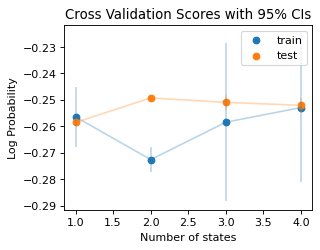

In [214]:
sticky.init_model(transitions='sticky',
                  transition_kwargs={'alpha': sticky.prior_alpha, 'kappa': 0})
lls, scores = sticky.fit_cv()
sticky.compare_k_states(scores)
LL = sticky.calc_log_likelihood(verbose=False)
LL_norm = sticky.calc_log_likelihood(verbose=False, normalize=True)

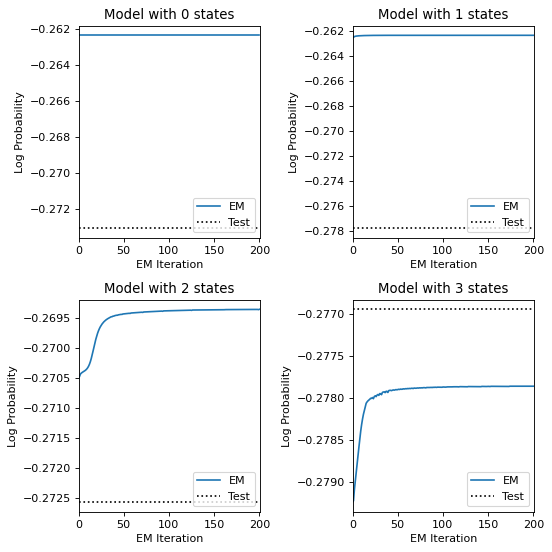

In [215]:
## Plot subplots of the log probabilities of the train and test models. Fit model final LL should be greater
# than or equal to true LL.
fig, axs = plt.subplots(2, 2, figsize=(7, 7), dpi=80,)
for i, (ax, ll) in enumerate(zip(axs.ravel(), lls)):
    ll = np.array(ll) / sticky.train_num_trials
    ax.plot(ll, label="EM")
    ax.plot([0, len(ll)], LL_norm['test'][i] * np.ones(2), ':k', label="Test")
    ax.legend(loc="lower right")
    ax.set(xlabel="EM Iteration", xlim=(0, len(ll)), ylabel="Log Probability",
           title=f'Model with {i} states')
plt.tight_layout()

In [216]:
bits = sticky.calc_log_likelihood(verbose=False, as_bits=True)
sticky.compare_k_states_no_err(bits, ylab='bits/trials')

Model with 0 states:
     train LL = 0.00
     test LL  = 0.00
Model with 1 states:
     train LL = 0.00
     test LL  = 0.00
Model with 2 states:
     train LL = 0.00
     test LL  = 0.00
Model with 3 states:
     train LL = 0.64
     test LL  = 0.60


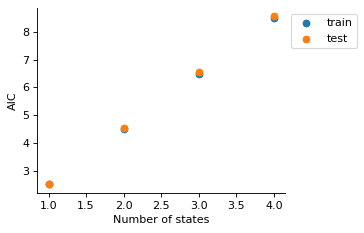

In [218]:
aic = sticky.calc_aic(LL)
sticky.compare_k_states_no_err(aic, ylab='AIC')

In [303]:
sticky.predict_state()
acc = sticky.predict_choice(accuracy=True, verbose=True)
sticky.plot_state_probs(3)

Model with 0 state(s) has a test predictive accuracy of 0.8967576791808873
Model with 1 state(s) has a test predictive accuracy of 0.8890784982935154
Model with 2 state(s) has a test predictive accuracy of 0.886518771331058
Model with 3 state(s) has a test predictive accuracy of 0.8848122866894198


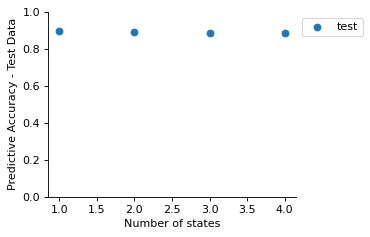

In [424]:
sticky.compare_k_states_no_err({'test': acc}, datasets=['test'], ylab='Predictive Accuracy - Test Data', ylim=(0, 1))

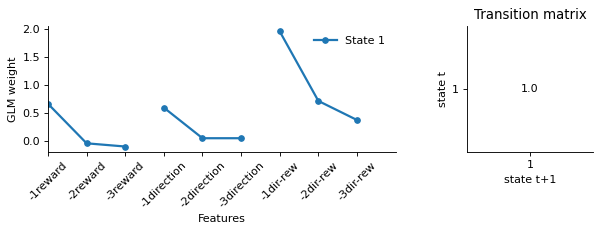

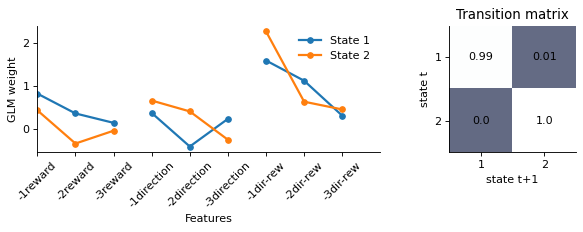

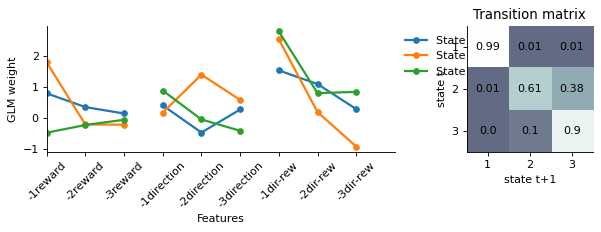

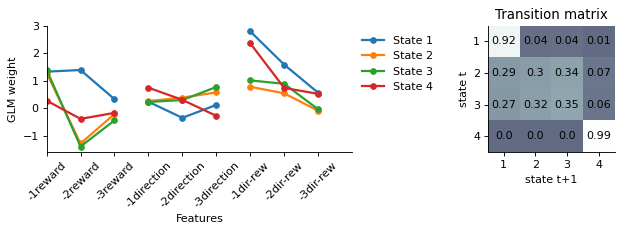

In [367]:
for i in range(4):
    sticky.plot_glm_weights(i)

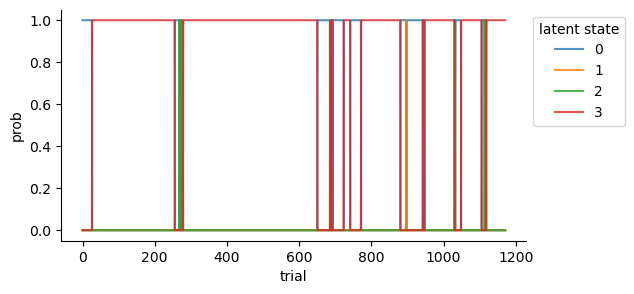

In [416]:
sticky.plot_state_probs(3, as_occupancy=True)

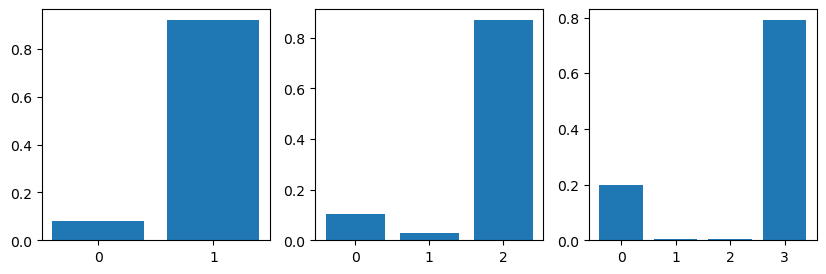

In [423]:
fig, ax = plt.subplots(ncols=3, figsize=(10,3))
for i in range(1,4):
    ax[i-1].bar(range(i+1), sticky.test_occupancy_rates[i])
    ax[i-1].set_xticks(range(i+1))

### 2b. Option 2 -- Stationary HMM -- input driven, looping through states. Much the same as above except, we are changing the transitions to 'standard'.

In [11]:
stationary_model_list = []
stationary_ll_list = []
stationary_train_scores = []
stationary_test_scores = []
for i in range(len(num_states)):
    from ssm import model_selection
    map_glmhmm = ssm.HMM(num_states[i], obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma),
                transitions="standard")
    train_scores, test_scores = ssm.model_selection.cross_val_scores(map_glmhmm, choices, inpts, heldout_frac=0.1, n_repeats=5, verbose=True)
    N_iters = 200
    stationary_ll = map_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize=False)
    stationary_ll_list.append(stationary_ll)
    stationary_train_scores.append(train_scores)
    stationary_test_scores.append(test_scores)
    stationary_model_list.append(map_glmhmm)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]